# ViT implementation practice

#### 1. **Tokenizer**, which takes an image and splits into several non-overlapping patches.

In [1]:
try:
    import einops
except:
    !pip install einops

In [2]:
import torch
from torch import nn

from einops import rearrange, repeat
from einops.layers.torch import Rearrange


class Image2Tokens(nn.Module):
    def __init__(self, image_size, dim, in_dim=3, patch_size=16, emb_dropout=0.):
        super().__init__()
        image_height, image_width = image_size
        num_patches = (image_height // patch_size) * (image_width // patch_size)
        patch_dim = in_dim * patch_size * patch_size
        self.to_patch_embedding = nn.Sequential(
            Rearrange('b c (h p1) (w p2) -> b (h w) (p1 p2 c)', p1=patch_size, p2=patch_size),
            nn.Linear(patch_dim, dim),
        )
        self.pos_embedding = nn.Parameter(torch.randn(1, num_patches + 1, dim))
        self.cls_token = nn.Parameter(torch.randn(1, 1, dim))
        self.dropout = nn.Dropout(emb_dropout)

    def forward(self, img):
        x = self.to_patch_embedding(img)
        b, n, _ = x.shape

        cls_tokens = repeat(self.cls_token, '() n d -> b n d', b=b)
        x = torch.cat((cls_tokens, x), dim=1)
        x += self.pos_embedding[:, :(n + 1)]
        return self.dropout(x)

In [3]:
tokenizer = Image2Tokens(image_size=(224,224), dim=768)
tokenizer(torch.randn(1,3,224,224)).shape

torch.Size([1, 197, 768])

#### 2. **Multi-Head Self-Attention**. Implement the following equation: $Softmax(\frac{QK^T}{\sqrt{d}})V$, where Q, K, V are embedded representations of input, $Q=w_Qx, K=w_Kx, V=w_Vx$, in multi-head manner.

In [4]:
class Attention(nn.Module):
    def __init__(self, dim, heads=8, dropout=0.):
        super().__init__()
        self.heads = heads
        self.scale = (dim // heads) ** -0.5
        self.attend = nn.Softmax(dim=-1)
        self.to_qkv = nn.Linear(dim, dim*3)
        self.to_out = nn.Sequential(
            nn.Linear(dim, dim),
            nn.Dropout(dropout)
        )

    def forward(self, x):
        qkv = self.to_qkv(x).chunk(3, dim = -1)
        q, k, v = map(lambda t: rearrange(t, 'b n (h d) -> b h n d', h=self.heads), qkv)
        dots = (q @ k.transpose(-1, -2)) * self.scale
        attn = self.attend(dots)
        out = attn @ v
        out = rearrange(out, 'b h n d -> b n (h d)')
        return self.to_out(out)

In [5]:
attn_op = Attention(dim=768)
attn_op(torch.randn(1,197,768)).shape

torch.Size([1, 197, 768])

#### 3. **FeedForwardNetwork (FFN)**. Implement $FFN=w_2 GELU(w_1x + b_1) + b_2$.

In [6]:
class FeedForwardNetwork(nn.Module):
    def __init__(self, dim, dropout=0.):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(dim, dim*4),
            nn.GELU(),
            nn.Dropout(dropout),
            nn.Linear(dim*4, dim),
            nn.Dropout(dropout)
        )
        
    def forward(self, x):
        return self.net(x)

In [7]:
ffn = FeedForwardNetwork(768)
ffn(torch.randn(1,197,768)).shape

torch.Size([1, 197, 768])

#### 4. Implement the **transformer encoder**, using prenorm shortcut style.

In [8]:
class PreNorm(nn.Module):
    def __init__(self, dim, fn):
        super().__init__()
        self.norm = nn.LayerNorm(dim)
        self.fn = fn
    def forward(self, x, **kwargs):
        return self.fn(self.norm(x), **kwargs)
    

class Transformer(nn.Module):
    def __init__(self, layers, dim, heads=8, dropout=0.):
        super().__init__()
        self.layers = nn.ModuleList([])
        for _ in range(layers):
            self.layers.append(nn.ModuleList([
                PreNorm(dim, Attention(dim, heads=heads, dropout=dropout)),
                PreNorm(dim, FeedForwardNetwork(dim, dropout=dropout))
            ]))
    def forward(self, x):
        for attn, ff in self.layers:
            x = attn(x) + x
            x = ff(x) + x
        return x

In [9]:
model = Transformer(layers=12, dim=768)
model(torch.randn(1,197,768)).shape

torch.Size([1, 197, 768])

#### 5. Package the **ViT model** with hyper-parameters configurable: (i) number of layers; (ii) hidden size; (iii) number of multiheads; (iv) image size (for tokenizer); (v) classifier 

In [10]:
class ViT(nn.Module):
    def __init__(self, layers, dim, heads, image_size, num_classes, patch_size=16, in_dim=3, dropout=0., emb_dropout=0.):
        super().__init__()
        self.tokenizer = Image2Tokens(image_size=image_size, dim=dim, in_dim=in_dim, patch_size=patch_size, emb_dropout=emb_dropout)
        self.transformer = Transformer(layers=layers, dim=dim, heads=heads, dropout=dropout)
        self.classifier = nn.Sequential(
            nn.LayerNorm(dim),
            nn.Linear(dim, num_classes)
        )

    def forward(self, img):
        out = self.tokenizer(img)
        out = self.transformer(out)
        out = out[:, 0]
        return self.classifier(out)

In [11]:
model = ViT(layers=12, dim=768, heads=12, image_size=(224,224), num_classes=1000)
model(torch.randn(1,3,224,224)).shape

torch.Size([1, 1000])

#### Sanity check the parameter counts are matches the numbers in the ViT paper: (i) 87M for ViT-Base; (ii) 304M for ViT-Large; (iii) 632M for ViT-Huge

In [12]:
def num_of_parameters(model):
    params = 0
    for i in model.parameters():
        params += i.numel()
    return params

In [13]:
vit_base = ViT(layers=12, dim=768, heads=12, image_size=(224,224), num_classes=1000)
vit_large = ViT(layers=24, dim=1024, heads=16, image_size=(224,224), num_classes=1000)
vit_huge = ViT(layers=32, dim=1280, heads=16, image_size=(224,224), num_classes=1000)

print(num_of_parameters(vit_base))
print(num_of_parameters(vit_large))
print(num_of_parameters(vit_huge))

86567656
304326632
632199400


#### The outputs should be:
```
86567656
304326632
632199400
```

---

# Train the implemented ViT on "Cat vs Dog Classification"

In [14]:
import os
import zipfile
import glob
from sklearn.model_selection import train_test_split

def UnzipTrainSet():
    with zipfile.ZipFile('train.zip') as train_zip:
        train_zip.extractall('data_dogcat')
        
def GetList():
    train_list = glob.glob(os.path.join('data_dogcat', 'train', '*.jpg'))
    return train_list

#### Train/Validation Split

In [15]:
import os
if not os.path.exists('train.zip'):
    !wget -O train.zip https://www.dropbox.com/s/wd28l8279yttbez/train.zip?dl=1

try:
    train_list = GetList()
    assert len(train_list) == 25000
except:
    os.makedirs('data_dogcat', exist_ok=True)
    UnzipTrainSet()
    train_list = GetList()
    assert len(train_list) == 25000

labels = [path.split('/')[-1].split('.')[0] for path in train_list]
split_train_list, split_val_list = train_test_split(train_list, 
                                                    test_size=0.2,
                                                    stratify=labels)
print(f"Train Data: {len(split_train_list)}")
print(f"Valid Data: {len(split_val_list)}")

Train Data: 20000
Valid Data: 5000


#### Dataloader and Augmentations (resize, horizontal flip)

In [16]:
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, Dataset
from PIL import Image

train_transforms = transforms.Compose(
    [
        transforms.Resize((224, 224)),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
    ]
)

val_transforms = transforms.Compose(
    [
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
    ]
)

class CatsDogsDataset(Dataset):
    def __init__(self, file_list, transform=None):
        self.file_list = file_list
        self.transform = transform

    def __len__(self):
        self.filelength = len(self.file_list)
        return self.filelength

    def __getitem__(self, idx):
        img_path = self.file_list[idx]
        img = Image.open(img_path)
        img_transformed = self.transform(img)

        label = img_path.split("/")[-1].split(".")[0]
        label = 1 if label == "dog" else 0

        return img_transformed, label

## Training with implemented ViT 

#### To run the training we need least 10GB of GPU memory

In [60]:
from tqdm.auto import tqdm
import torch
from torch import nn
import torch.optim as optim
from torch.optim.lr_scheduler import CosineAnnealingLR

batch_size = 32
epochs = 5
lr = 1e-3
weight_decay = 1e-6
device = 'cuda'

model = ViT(layers=9, dim=192, heads=12, image_size=(224, 224), num_classes=2)
model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)
scheduler = CosineAnnealingLR(optimizer, epochs)

train_data = CatsDogsDataset(split_train_list, transform=train_transforms)
val_data = CatsDogsDataset(split_val_list, transform=val_transforms)

train_loader = DataLoader(dataset=train_data, batch_size=batch_size, shuffle=True, num_workers=2, pin_memory=True, persistent_workers=True)
val_loader = DataLoader(dataset=val_data, batch_size=batch_size, shuffle=False, num_workers=1, pin_memory=True, persistent_workers=True)


for epoch in range(epochs):
    epoch_loss = 0
    epoch_accuracy = 0

    model.train()
    for data, label in tqdm(train_loader):
        data = data.to(device)
        label = label.to(device)

        output = model(data)
        loss = criterion(output, label)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        acc = (output.argmax(dim=1) == label).float().mean()
        epoch_accuracy += acc / len(train_loader)
        epoch_loss += loss / len(train_loader)

        
    model.eval()    
    with torch.inference_mode():
        epoch_val_accuracy = 0
        epoch_val_loss = 0
        for data, label in tqdm(val_loader):
            data = data.to(device)
            label = label.to(device)

            val_output = model(data)
            val_loss = criterion(val_output, label)

            acc = (val_output.argmax(dim=1) == label).float().mean()
            epoch_val_accuracy += acc / len(val_loader)
            epoch_val_loss += val_loss / len(val_loader)
            

    print(
        f"Epoch : {epoch+1} - loss : {epoch_loss:.4f} - acc: {epoch_accuracy:.4f} - val_loss : {epoch_val_loss:.4f} - val_acc: {epoch_val_accuracy:.4f}\n"
    )
    
    scheduler.step()

  0%|          | 0/625 [00:00<?, ?it/s]

  0%|          | 0/157 [00:00<?, ?it/s]

Epoch : 1 - loss : 0.7008 - acc: 0.5442 - val_loss : 0.7058 - val_acc: 0.5006



  0%|          | 0/625 [00:00<?, ?it/s]

  0%|          | 0/157 [00:00<?, ?it/s]

Epoch : 2 - loss : 0.6705 - acc: 0.5902 - val_loss : 0.6550 - val_acc: 0.6262



  0%|          | 0/625 [00:00<?, ?it/s]

  0%|          | 0/157 [00:00<?, ?it/s]

Epoch : 3 - loss : 0.6341 - acc: 0.6352 - val_loss : 0.6217 - val_acc: 0.6503



  0%|          | 0/625 [00:00<?, ?it/s]

  0%|          | 0/157 [00:00<?, ?it/s]

Epoch : 4 - loss : 0.5966 - acc: 0.6752 - val_loss : 0.5875 - val_acc: 0.6795



  0%|          | 0/625 [00:00<?, ?it/s]

  0%|          | 0/157 [00:00<?, ?it/s]

Epoch : 5 - loss : 0.5701 - acc: 0.6989 - val_loss : 0.5767 - val_acc: 0.6909



## (Optional) Using ImageNet pretrained weights, using `timm` library

#### we use half batch size to fit the smallest pretrained model, ViT Base, however it still needs at least 12G GPU memory to run this cell

In [18]:
try:
    import timm
except:
    !pip install timm

/opt/conda/lib/python3.8/site-packages/apex/pyprof/__init__.py:5: FutureWarning: pyprof will be removed by the end of June, 2022
  warnings.warn("pyprof will be removed by the end of June, 2022", FutureWarning)


In [19]:
import timm

class PretrainedViT(nn.Module):
    def __init__(self, num_class):
        super().__init__()
        self.pretrained_model = timm.create_model('vit_base_patch16_224_in21k', True)
        self.classifier = nn.Linear(768, num_class)
    
    def forward(self, x):
        x = self.pretrained_model.forward_features(x)
        return self.classifier(x)

In [20]:
from tqdm.auto import tqdm
import torch
from torch import nn
import torch.optim as optim
from torch.optim.lr_scheduler import CosineAnnealingLR

batch_size = 16
epochs = 5
lr = 1e-4
weight_decay = 1e-6
device = 'cuda'

pretrained_model = PretrainedViT(2)
pretrained_model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(pretrained_model.parameters(), lr=lr, weight_decay=weight_decay)
scheduler = CosineAnnealingLR(optimizer, epochs)


for epoch in range(epochs):
    epoch_loss = 0
    epoch_accuracy = 0

    pretrained_model.train()
    for data, label in tqdm(train_loader):
        data = data.to(device)
        label = label.to(device)

        output = pretrained_model(data)
        loss = criterion(output, label)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        acc = (output.argmax(dim=1) == label).float().mean()
        epoch_accuracy += acc / len(train_loader)
        epoch_loss += loss / len(train_loader)

            
    pretrained_model.eval()
    with torch.inference_mode():
        epoch_val_accuracy = 0
        epoch_val_loss = 0
        for data, label in tqdm(val_loader):
            data = data.to(device)
            label = label.to(device)

            val_output = pretrained_model(data)
            val_loss = criterion(val_output, label)

            acc = (val_output.argmax(dim=1) == label).float().mean()
            epoch_val_accuracy += acc / len(val_loader)
            epoch_val_loss += val_loss / len(val_loader)


    print(
        f"Epoch : {epoch+1} - loss : {epoch_loss:.4f} - acc: {epoch_accuracy:.4f} - val_loss : {epoch_val_loss:.4f} - val_acc: {epoch_val_accuracy:.4f}\n"
    )
    
    scheduler.step()

  0%|          | 0/1250 [00:00<?, ?it/s]

  0%|          | 0/313 [00:00<?, ?it/s]

Epoch : 1 - loss : 0.1229 - acc: 0.9532 - val_loss : 0.1071 - val_acc: 0.9557



  0%|          | 0/1250 [00:00<?, ?it/s]

  0%|          | 0/313 [00:00<?, ?it/s]

Epoch : 2 - loss : 0.0949 - acc: 0.9635 - val_loss : 0.0903 - val_acc: 0.9629



  0%|          | 0/1250 [00:00<?, ?it/s]

  0%|          | 0/313 [00:00<?, ?it/s]

Epoch : 3 - loss : 0.0583 - acc: 0.9784 - val_loss : 0.0579 - val_acc: 0.9776



  0%|          | 0/1250 [00:00<?, ?it/s]

  0%|          | 0/313 [00:00<?, ?it/s]

Epoch : 4 - loss : 0.0221 - acc: 0.9922 - val_loss : 0.0597 - val_acc: 0.9780



  0%|          | 0/1250 [00:00<?, ?it/s]

  0%|          | 0/313 [00:00<?, ?it/s]

Epoch : 5 - loss : 0.0056 - acc: 0.9983 - val_loss : 0.0456 - val_acc: 0.9838



#### Since ViT is a data-hungry model, the significant accuracy improvement can be observed using large dataset pretrained weights. This suggests always consider using the pretrained model if possible.

# (Extra) Visual inspect the learned attention weights

#### The following codes only applicable on our implemented ViT. Some modifications are needed for `timm` ViTs.

In [21]:
from functools import wraps
import torch
from torch import nn


def find_modules(nn_module, type):
    return [module for module in nn_module.modules() if isinstance(module, type)]

class Recorder(nn.Module):
    def __init__(self, vit, device = None):
        super().__init__()
        self.vit = vit

        self.data = None
        self.recordings = []
        self.hooks = []
        self.hook_registered = False
        self.ejected = False
        self.device = device

    def _hook(self, _, input, output):
        self.recordings.append(output.clone().detach())

    def _register_hook(self):
        modules = find_modules(self.vit.transformer, Attention)
        for module in modules:
            handle = module.attend.register_forward_hook(self._hook)
            self.hooks.append(handle)
        self.hook_registered = True

    def eject(self):
        self.ejected = True
        for hook in self.hooks:
            hook.remove()
        self.hooks.clear()
        return self.vit

    def clear(self):
        self.recordings.clear()

    def record(self, attn):
        recording = attn.clone().detach()
        self.recordings.append(recording)

    def forward(self, img):
        assert not self.ejected, 'recorder has been ejected, cannot be used anymore'
        self.clear()
        if not self.hook_registered:
            self._register_hook()

        pred = self.vit(img)

        # move all recordings to one device before stacking
        target_device = self.device if self.device is not None else img.device
        recordings = tuple(map(lambda t: t.to(target_device), self.recordings))

        attns = torch.stack(recordings, dim = 1) if len(recordings) > 0 else None
        return pred, attns

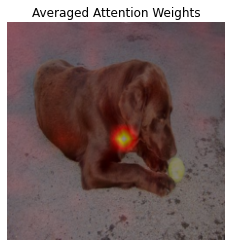

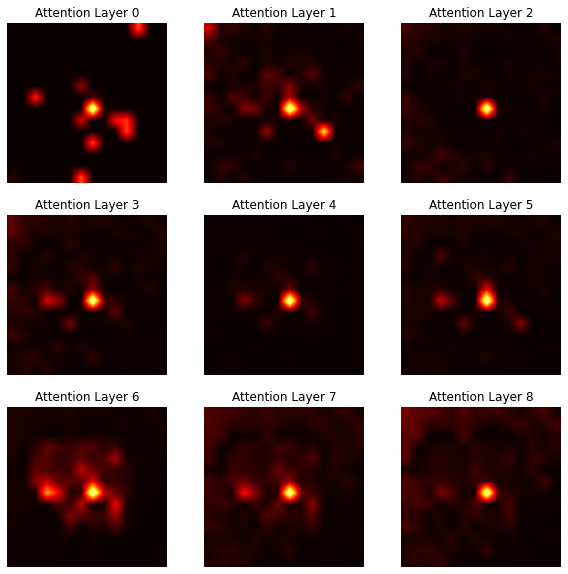

In [72]:
import cv2
import matplotlib.pyplot as plt

patch_size = 16
image_size = 224
select_index = -1 # change the index to visualize different images

model.cpu()
model.eval()
v = Recorder(model) # load our implemented ViT

data, label = next(iter(val_loader))
_, attns = v(data)

m = attns[select_index][:, :, 0, 1:].sum(1)
plt.imshow(data[select_index].permute(1,2,0))
plt.imshow(cv2.resize(m[-1].reshape(image_size//patch_size, image_size//patch_size).numpy(), (image_size, image_size)), cmap='hot', alpha=0.5)
plt.axis('off')
plt.title('Averaged Attention Weights')
plt.show()

_, arr = plt.subplots(3, 3, figsize=(10, 10))
for idx, i in enumerate(m):
    arr[idx//3, idx%3].imshow(cv2.resize(i.reshape(image_size//patch_size, image_size//patch_size).numpy(), (image_size, image_size)), cmap='hot')
    arr[idx//3, idx%3].axis('off')
    arr[idx//3, idx%3].set_title(f'Attention Layer {idx}')
plt.show()

#### Note we trained our implemented ViT for only 5 epochs. The visualization result may not be converged.

### Here we provide the pretrained model (trained for 100 epochs) for visualization. (accuracy 0.7613)

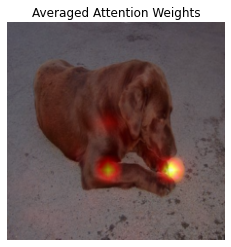

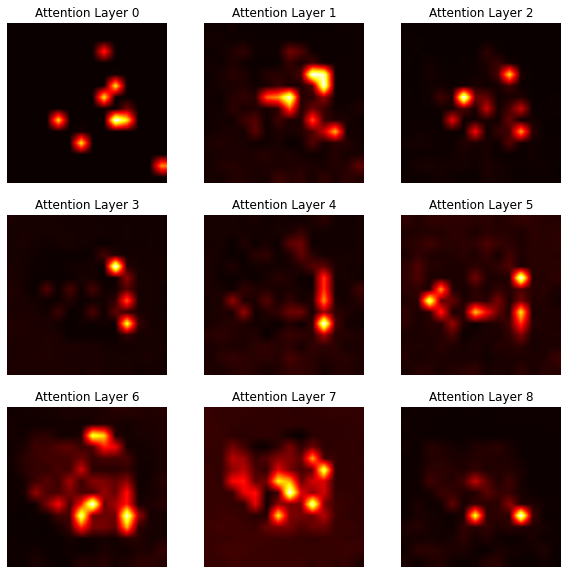

In [73]:
if not os.path.exists('model.pt'):
    !wget https://www.dropbox.com/s/ffj5j1kdt30racl/model.pt?dl=1 # trained 100 epochs, acc: 0.7613


patch_size = 16
image_size = 224
select_index = -1 # change the index to visualize different images

model = ViT(layers=9, dim=192, heads=12, image_size=(224, 224), num_classes=2)
model.load_state_dict(torch.load('model.pt')['weight'])
model.cpu()
model.eval()
v = Recorder(model) # load our implemented ViT

data, label = next(iter(val_loader))
pred, attns = v(data)

m = attns[select_index][:, :, 0, 1:].sum(1)
plt.imshow(data[select_index].permute(1,2,0))
plt.imshow(cv2.resize(m[-1].reshape(image_size//patch_size, image_size//patch_size).numpy(), (image_size, image_size)), cmap='hot', alpha=0.5)
plt.axis('off')
plt.title('Averaged Attention Weights')
plt.show()

_, arr = plt.subplots(3, 3, figsize=(10, 10))
for idx, i in enumerate(m):
    arr[idx//3, idx%3].imshow(cv2.resize(i.reshape(image_size//patch_size, image_size//patch_size).numpy(), (image_size, image_size)), cmap='hot')
    arr[idx//3, idx%3].axis('off')
    arr[idx//3, idx%3].set_title(f'Attention Layer {idx}')
plt.show()